In [1]:
from efficient_kan import KAN
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from scipy.interpolate import BSpline
from torch.utils.data import DataLoader
from kan.utils import create_dataset

# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
def visualize_kan(weight, scale_base):
    # define B-spline parameters
    grid_size = 3
    spline_order = 3
    weights = weight
    knot_vector = np.concatenate(([-1] * spline_order, np.linspace(-1, 1, grid_size), [1] * spline_order))

    t = np.linspace(-1, 1, 100)

    spline = BSpline(knot_vector, weights, spline_order)
    spline_values = spline(t)
    
    silu = nn.SiLU()
    bias = silu(torch.tensor(t))


    print(len(bias))
    print(len(spline_values))

    bias_set = set(bias.numpy())
    spline_set = set(spline_values)

    intersection = np.intersect1d(bias_set, spline_set)
    union = np.union1d(bias_set, spline_set)

    jac = len(intersection)/len(union)
    print(f"jaccard index: {jac}")

    spline_values = spline_values + bias.numpy()*scale_base.detach().numpy()

    plt.figure(figsize=(4, 3))
    plt.plot(t, spline_values, label='B-spline curve')
    plt.scatter(np.linspace(-1, 1, len(weights)), weights, color='red', label='Control points')
    plt.title('B-spline Curve')
    plt.xlabel('t')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()



In [63]:
model = KAN([55,8,2], grid_size=5)
# visualize_kan(model.layers[0].spline_weight[1][0].detach().numpy(), model.layers[0].base_weight[1][0])

checkpoint = torch.load("models/saved/KAN/lunar-sweep-101.pth")
model.forward(torch.randn(1,55))



tensor([[0.0968, 0.1339]], grad_fn=<AddBackward0>)

100
100
jaccard index: 0.0


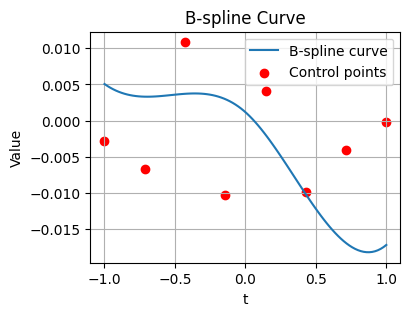

tensor(-0.2922, grad_fn=<SelectBackward0>)
tensor([ 0.0002, -0.0041, -0.0150,  0.0127,  0.0068, -0.0152,  0.0090,  0.0035],
       grad_fn=<SelectBackward0>)


In [64]:
visualize_kan(model.layers[0].spline_weight[1][1].detach().numpy(), model.layers[1].base_weight[0][0]/10)


print(model.layers[1].base_weight[0][0])

print(model.layers[1].spline_weight[0][0])

# get difference between max and min value of spline_weight



In [34]:
model.load_state_dict(checkpoint)


<All keys matched successfully>

In [70]:
# most important feature
l = 0
i = 0


{'diff': tensor(0.0219, grad_fn=<SubBackward0>), 'base': tensor(0.0002, grad_fn=<AbsBackward0>), 'idx': [0, 0, 9]}
{'diff': tensor(0.0326, grad_fn=<SubBackward0>), 'base': tensor(0.0002, grad_fn=<AbsBackward0>), 'idx': [0, 3, 36]}
{'diff': tensor(0.0161, grad_fn=<SubBackward0>), 'base': tensor(0.0022, grad_fn=<AbsBackward0>), 'idx': [0, 4, 41]}
{'diff': tensor(0.0326, grad_fn=<SubBackward0>), 'base': tensor(0.0024, grad_fn=<AbsBackward0>), 'idx': [0, 3, 44]}
456
0 4 41
100
100
jaccard index: 0.0


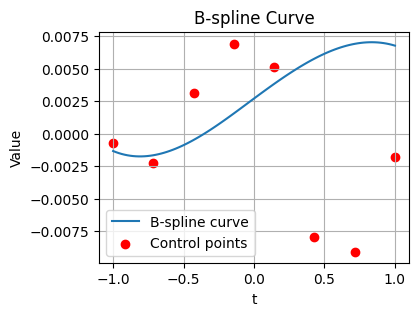

In [72]:


base_diff = []

for l,layer in enumerate(model.layers):
    for i in range(layer.base_weight.shape[0]):
        for j in range(layer.base_weight.shape[1]):
            diff = layer.spline_weight[i][j].max() - layer.spline_weight[i][j].min()
            base = layer.base_weight[i][j]

            edge = {
                "diff": diff,
                "base": abs(base),
                "idx": [l,i,j],
            }
            base_diff.append(edge)

diff = sorted(base_diff, key=lambda x: x["diff"], reverse=True)
base = sorted(base_diff, key=lambda x: x["base"], reverse=False)

print(base[0])
print(base[1])
print(base[2])
print(base[3])

print(len(base))

# top 5 idx from base
# for t in range(0,2300,95):
#     l = base[t]['idx'][0]
#     i = base[t]['idx'][1]
#     j = base[t]['idx'][2]
#     print(l,i,j)
#     visualize_kan(model.layers[l].spline_weight[i][j].detach().numpy(), model.layers[l].base_weight[i][j])

                          

t = 2
l = base[t]['idx'][0]
i = base[t]['idx'][1]
j = base[t]['idx'][2]
print(l,i,j)
visualize_kan(model.layers[l].spline_weight[i][j].detach().numpy(), model.layers[l].base_weight[i][j])

            
        

# visualize_kan(model.layers[0].spline_weight[22][23].detach().numpy(), model.layers[0].base_weight[22][23])
